# Imports 

In [114]:
#%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import HTML
import seaborn as sns 
from statsmodels.tsa.stattools import ccf, acf, pacf
from scipy.stats import zscore, norm, kurtosis, skew
import pandas as pd

# Helper functions

In [216]:
def Cluster_splitter(spks:np.array, xpos:np.array, ypos:np.array, labels:np.array, xmin:int, xmax:int, normalize:bool = True):

    """ 
    This function takes the original neuron x time matrix and constructs an object that cointain 
    each subset of neurons per cluster

    Parameters
    ----------

    spks : np.array
        Array to be splitted (original neuron x time array)
    xpos : np.array 
        Array of x positions to be splitted
    ypos : np.array 
        Array of y positions to be splitted
    labels : np.array 
        Array containing the labels of the neurons (output of the clustering algorithm)
    xmin : int
        Initial offset 
    xmax : int 
        Final offset
    normalize : bool
        Boolean flag to apply normalization

    Returns
    ----------
    splitted_spks: np.array
        numpy object that contains each cluster subset per entry
    splitted_xpos: np.array
        numpy object that contains each xposition coordinate per cluster subset, per entry
    splitted_ypos: np.array
        numpy object that contains each yposition coordinate per cluster subset, per entry
    """

    clusters = np.unique(labels)
    splitted_spks = np.empty(len(clusters),dtype=object)
    splitted_xpos = np.empty(len(clusters),dtype=object)
    splitted_ypos = np.empty(len(clusters),dtype=object)
    splitted_sn = np.empty(len(clusters),dtype=object)

    if xmax == None:
        xmax = spks.shape[1]

    for clust in clusters:
        selector = np.where(labels==clust)[0]
        if normalize == False:
            selected_spks = spks[selector,xmin:xmax]
        else:
            selected_spks = zscore(spks[selector,xmin:xmax], axis = 1)
            selected_spks -= selected_spks.mean(axis=0)
        
        splitted_xpos[clust] = xpos[selector]
        splitted_ypos[clust] = ypos[selector]
        splitted_spks[clust] = selected_spks
        splitted_sn[clust] = Get_superneuron(selected_spks)
    return splitted_spks, splitted_xpos, splitted_ypos, splitted_sn 



def Get_subpopulationvsAll(spks: np.array , labels: np.array, clust: int, xmin:int, xmax:int, normalize:bool=True):

    """
    Utility function that splits the data in one vs all fashion

     Parameters
    ----------

    spks : np.array
        Array to be splitted (original neuron x time array)
    labels : np.array 
        Array containing the labels of the neurons (output of the clustering algorithm)
    xmin : int
        Initial offset 
    xmax : int 
        Final offset
    normalize : bool
        Boolean flag to apply normalization

    Returns
    ----------
    selected_spks: np.array
        specified cluster
    rest_pop: np.array
        the rest of the population
    """
    

    selector = np.where(labels==clust)[0]
    not_selector = np.where(labels!=clust)[0]
    if normalize == False:
        selected_spks = spks[selector,xmin:xmax]
        rest_pop =  spks[not_selector,xmin:xmax]
    else:
        selected_spks = zscore(spks[selector,xmin:xmax], axis = 1)
        rest_pop =  zscore(spks[not_selector,xmin:xmax], axis = 1)
        selected_spks -= selected_spks.mean(axis=0)
        rest_pop -=  rest_pop.mean(axis=0)
    return selected_spks, rest_pop


def Get_superneuron(cluster: np.array):

    """ 
    Computes the mean over all neurons in the cluster 

    Parameters
    ----------

    cluster : np.array
        Array containing the neurons in a given cluster

    Returns
    ----------
        numpy array containg the mean over all neurons in the cluster
    """

    return cluster.mean(axis=0)


def ClusterVisualizer(selected_spks:np.array):
    """
    Simple cluster visualizer (neurons x time) and superneuron

    Parameters
    ----------
    selected_spks: np.array
        Array cointaing the cluster to be visualized
    """

    f, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(7,7), dpi=150)
    ax1.imshow(selected_spks, vmin=0, vmax=2, cmap='gray_r', aspect='auto')
    ax1.set_ylabel('neuron (id)')
    ax2.plot(Get_superneuron(selected_spks), color= 'k')
    ax2.set_title('SuperNeuron activity')
    ax2.set_ylabel('Activity (a.u)')
    ax2.set_xlabel('time $(ms)$')
    sns.despine()

def Get_ACF_PACF(superneuron:np.array, lags:int=30):

    """
    Gets the autocorr and partial autocorr of the superneuron 

    Parameters
    ----------
    superneuron: np.array
        Array cointaing superneuron activity
    lags: int
        number of lags to be computed

    Returns
    ----------

    sn_acf: np.array
        Array containing the autocorrelation of the superneuron activity
    sn_pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    """
    sn_acf = acf(superneuron, nlags=lags, fft=True)
    sn_pacf = pacf(superneuron, nlags=lags)

    return sn_acf,sn_pacf

def ACFViz(superneuron:np.array, acf:np.array , alpha=0.025):
    

    """
    Plots the autocorrelation of the signal with CI for a given alpha

    Parameters
    ----------
    superneuron: np.array
        Array cointaing superneuron activity
    acf: np.array
        Array containing the autocorrelation of the superneuron activity
    pacf: np.array
        Array containing the partial autocorrelation of the superneuron activity  
    alpha: Two tailed (!!) confidence value at 95% 
    """

    quantile = norm.ppf(1-alpha)
    ac_se = np.sqrt(1+(2*np.sum(acf**2)))
    acf_ci = quantile * ((ac_se)/np.sqrt(len(superneuron)))
    #pacf_ci = quantile / np.sqrt(len(superneuron))
    f, (ax1) = plt.subplots(1,1,sharex=True, figsize=(7,7), dpi=150)
    
    ax1.stem(acf)
    ax1.axhline(y=acf_ci,linestyle='--',color='gray', label=f"{(1 - (alpha*2))*100} % Confidence interval")
    ax1.axhline(y=-acf_ci,linestyle='--',color='gray')
    ax1.set_ylabel('Autocorrelation')
    ax1.legend()
    sns.despine()


def Get_CCF(Splitted_spks:np.array, cluster_ref:int, cluster_comp:int):

    """
    Computes the crosscorrelation between two superneurons


    Parameters:
    -----------

    Splitted_spks: np.array
        numpy object that contains each cluster subset per entry
    cluster_ref: int
        label of the reference cluster
    cluster_comp: int
        label of the compared cluster

    Returns:
    ----------
    full: np.array
        full crosscorrelogram between the two signals, reference vs comparison in the positive lags 
        and comparison vs reference in the negative lags
    a: np.array
        crosscorrelogram between the reference and comparison signal (positive lags part of the full vector)
    b: np.array
        crosscorrelogram between the comparison and reference signal (negative lags part of the full vector)
    """
    sn0 = Get_superneuron(Splitted_spks[cluster_ref])
    sn1 = Get_superneuron(Splitted_spks[cluster_comp])
    a = ccf(sn0,sn1,adjusted=False,fft=True)
    b = ccf(sn1,sn0,adjusted=False,fft=True)
    c= b[::-1]
    full = np.append(c,a)
    return full, a, b

def plot_ccf(ccf: np.array):


    """
    Plots the crosscorrelagram given the ccf vector


    Parameters:
    -----------

    ccf: np.array
        full ccf vector
    """

    plt.figure(figsize=(7,7), dpi=150)
    x = np.arange(-((ccf.shape[0]+1)/2)+1,(ccf.shape[0])/2)
    plt.axhline(y=0,linestyle='-',color='red',linewidth=3)
    plt.plot(x,ccf,color='k')
    plt.ylabel('Cross-correlation')
    plt.xlabel('Lags')
    sns.despine()

def compute_decay(data:np.array,interpolation_factor:int=100):

    """
    Interpolates data by a interpolation_factor, and then computes tau 

    Parameters:
    -----------

    data : np.array
        Array containing the data 

    Returns:
    ----------
    tau : np.float32
        exponential decay constant

    """

    from scipy.interpolate import interp1d
    x = np.arange(len(data))

    f = interp1d(x,data)

    x_new = np.linspace(0,len(data)-1,num=len(data)*interpolation_factor)

    interp_data = f(x_new)

    tau = (interp_data>np.exp(-1)).nonzero()[0][-1] #return the last not zero index, i.e, the last True 

    return x_new[tau]

def ClusterStacker(Splitted_spks:np.array, labels:np.array):
    """ 
    It stacks vertically the set of clusters given by the labels
    
    Arguments:
    ----------

    Splitted_spks: np.array
        np object that has each cluster per entry
    labels: np.array
        array containing the labels of the clusters to be stacked

    Returns:
    --------

    StackedClusters: np.array
        Those selected clusters stacked vertically
    
    """
    for i,idx in enumerate(labels):
        if i == 0:
            StackedClusters = Splitted_spks[idx]
        else: 
            clustertostack = Splitted_spks[idx]
            StackedClusters = np.vstack((StackedClusters,clustertostack))
    return StackedClusters


# Data loading
## Spike extraction

In [3]:
data_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont'
video_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont/cam/'

dbs = {'mouse_name': 'TX60', 'date': '2020_10_20', 'exp': '2', 'cam': ['0', '1']}

In [4]:
dat = np.load(os.path.join(data_root, 'spont_2cam_%s_%s.npz'%
                  (dbs['mouse_name'], dbs['date'])))

spks = dat['spks'].astype(np.float32)
ypos = dat['ypos'].astype(np.float32)
xpos = dat['xpos'].astype(np.float32)

Exploring the `npz` data structure:

In [5]:
dat.files

['spks', 'tcam', 'ypos', 'xpos', 'tneural', 'run']

In [6]:
spks.shape

(42568, 23185)

(neurons) x n_samples

# Rastermap fit

In [7]:
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/RasterMap')
from rastermap import mapping

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
n_clusters = 100 

In [9]:
RM_model = mapping.Rastermap(smoothness=1, 
                           n_clusters=n_clusters, 
                           n_PCs=128, 
                           ts=0.9,
                           time_lag_window=0,
                           grid_upsample=10,
                           n_splits=0).fit(spks, normalize=True) 

n_PCs = 128 computed, time 33.18
landmarks computed and embedded, time 50.46
grid upsampled, time 53.45


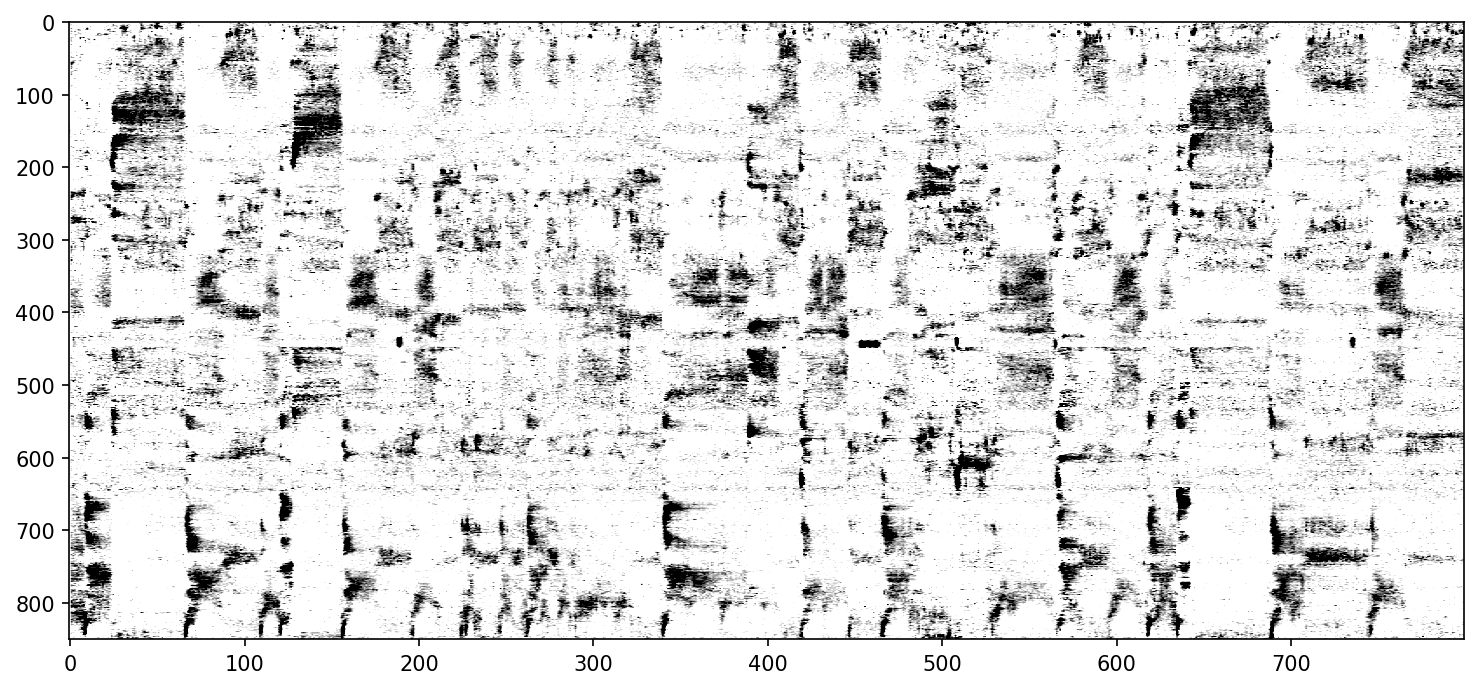

In [10]:
plt.figure(figsize=(12,12), dpi=150)
xmin=0
xmax=xmin+800
plt.subplot(2,1,1)
plt.imshow(zscore(RM_model.X_embedding[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Rastermap cluster inspection 

In [174]:
Splitted_spks, Splitted_xpos, Splitted_ypos, Splitted_sn = Cluster_splitter(spks, xpos, ypos, 
                                labels=RM_model.embedding_clust, 
                                xmin = 0, 
                                xmax = 800, 
                                normalize=True,
                                )

# Timescales

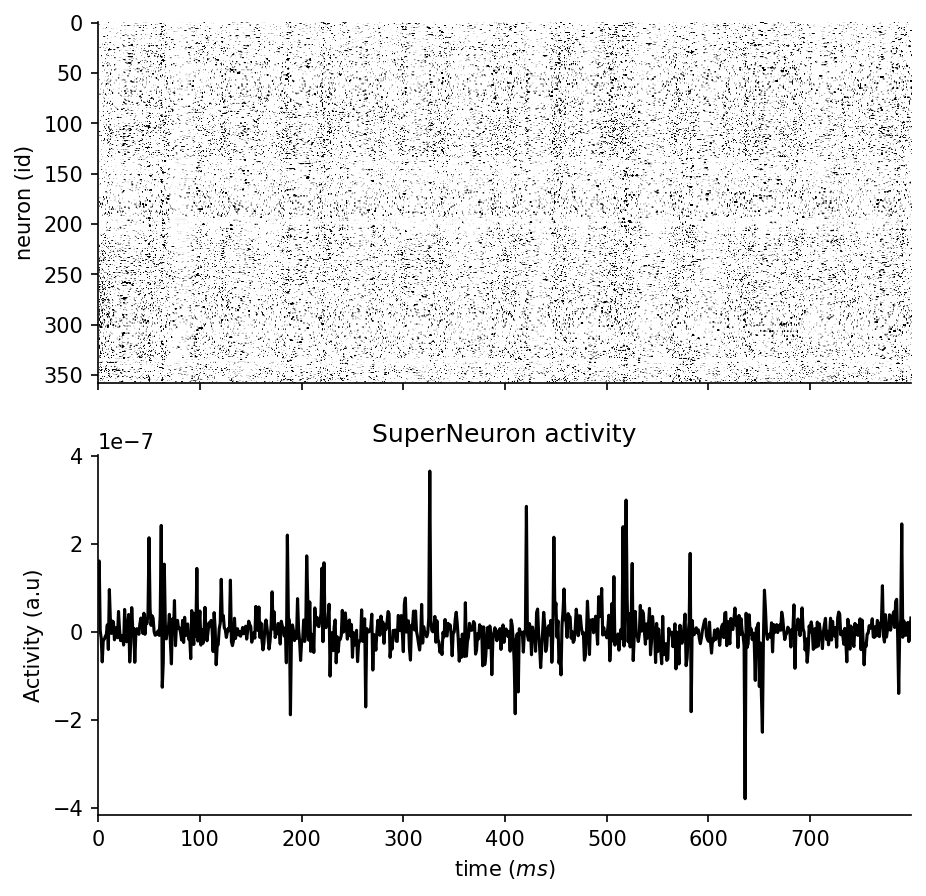

In [217]:
Cluster0 = Splitted_spks[0]
ClusterVisualizer(Cluster0)

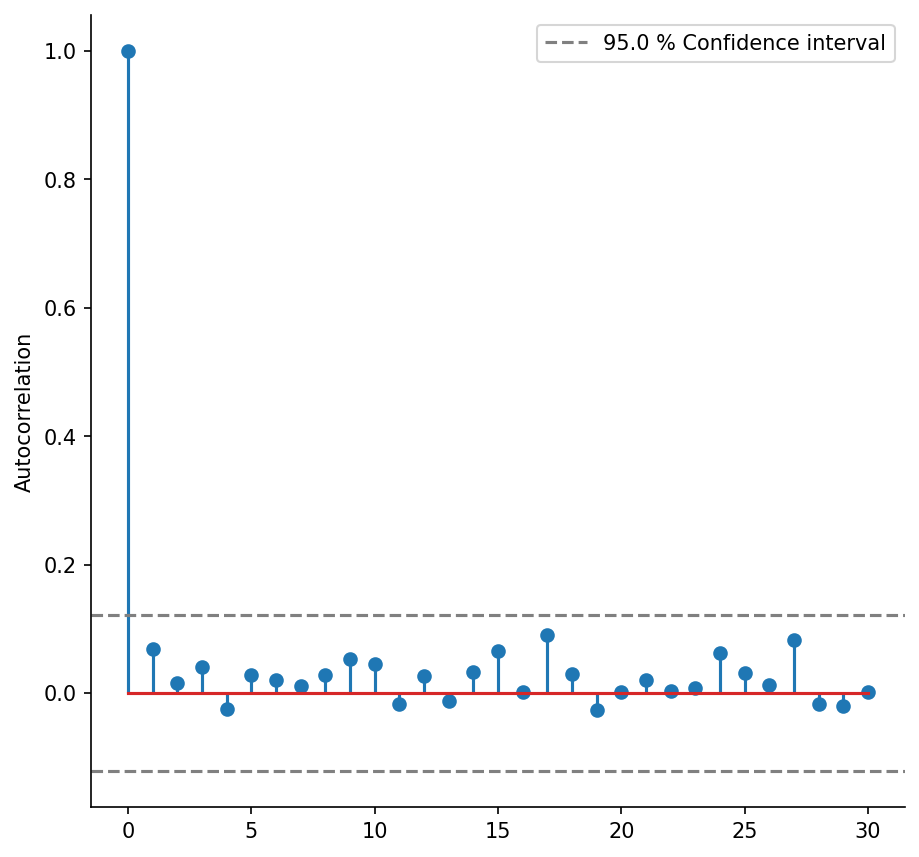

In [218]:
sn0 = Splitted_sn[0]
sn0_acf, sn0_pacf = Get_ACF_PACF(sn0)
ACFViz(sn0,sn0_acf)

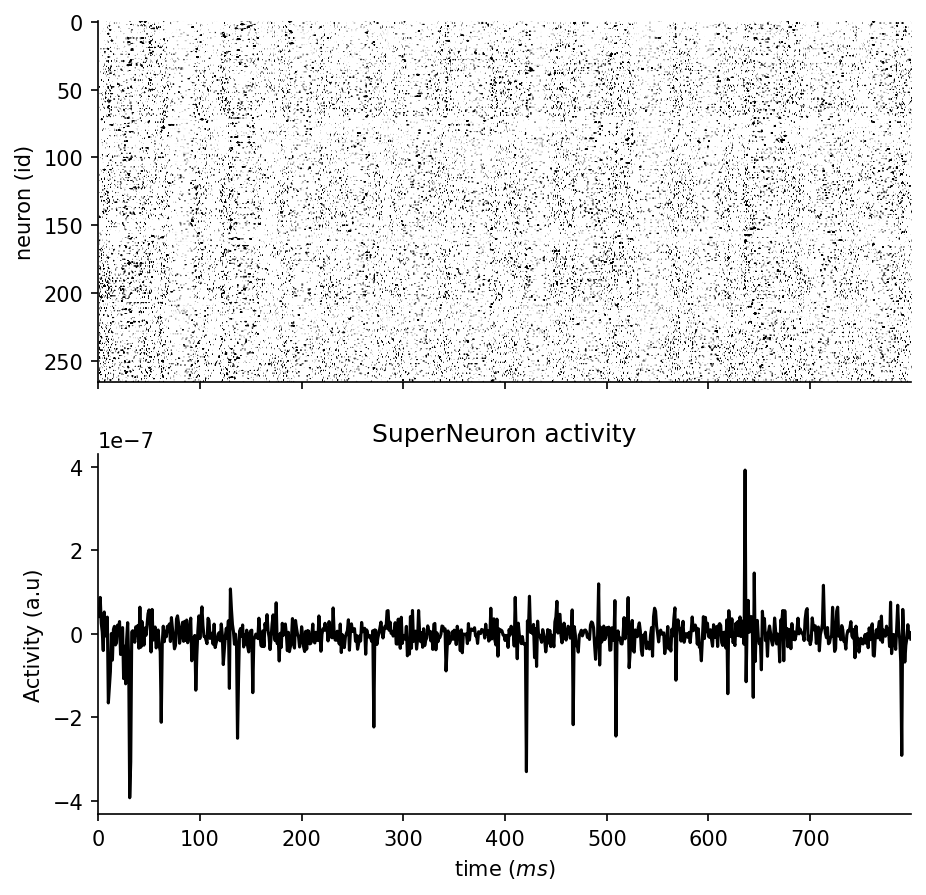

In [177]:
Cluster1 = Splitted_spks[1]
ClusterVisualizer(Cluster1)

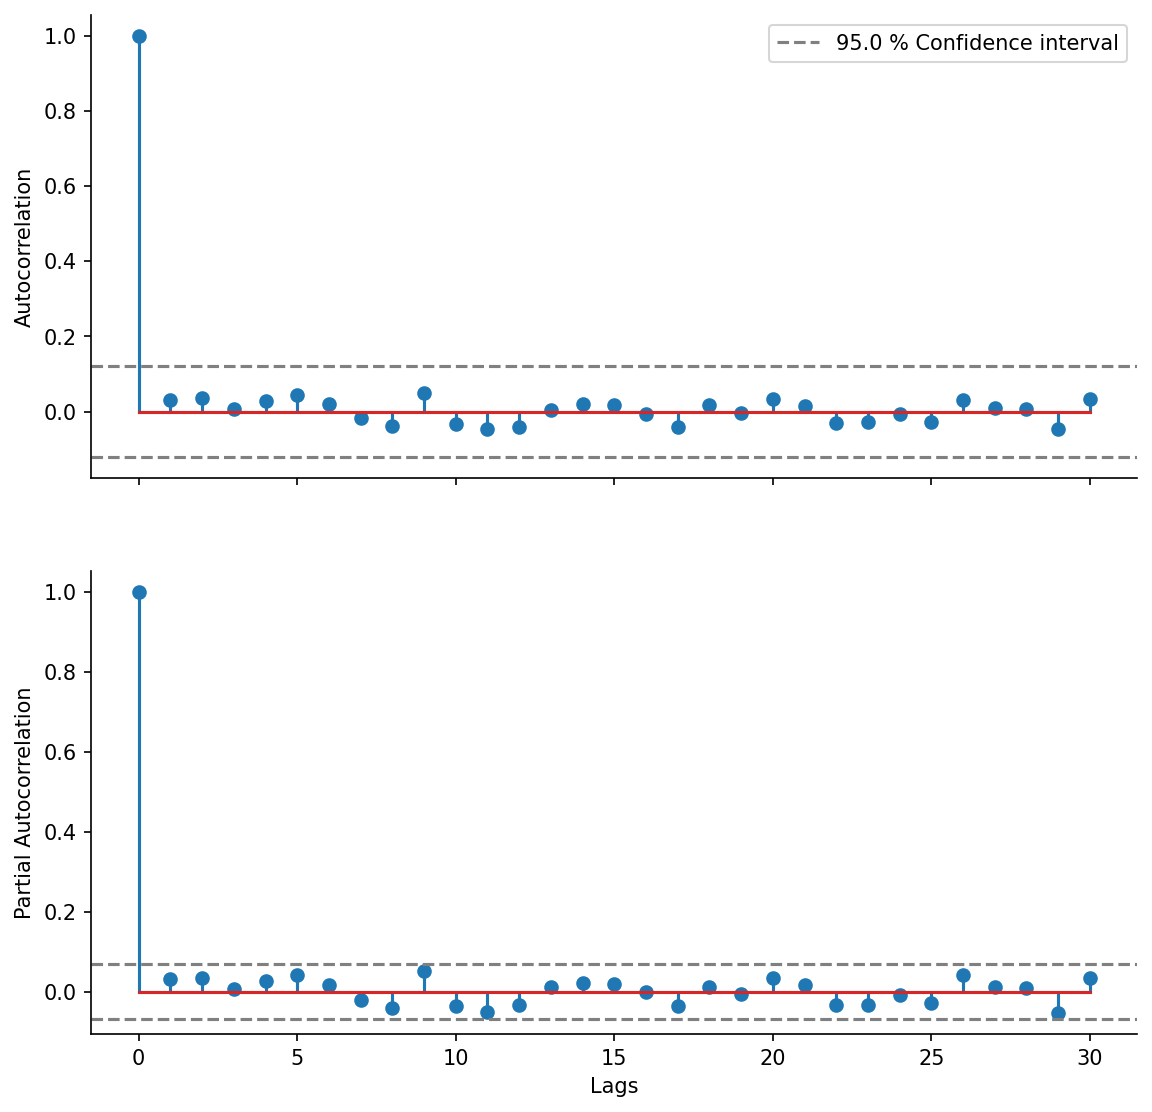

In [182]:
sn1 = Splitted_sn[1]
sn1_acf, sn1_pacf = Get_ACF_PACF(sn1)
ACFViz(sn1,sn1_acf,sn1_pacf)

# Computing the decay of the acf for each cluster: 

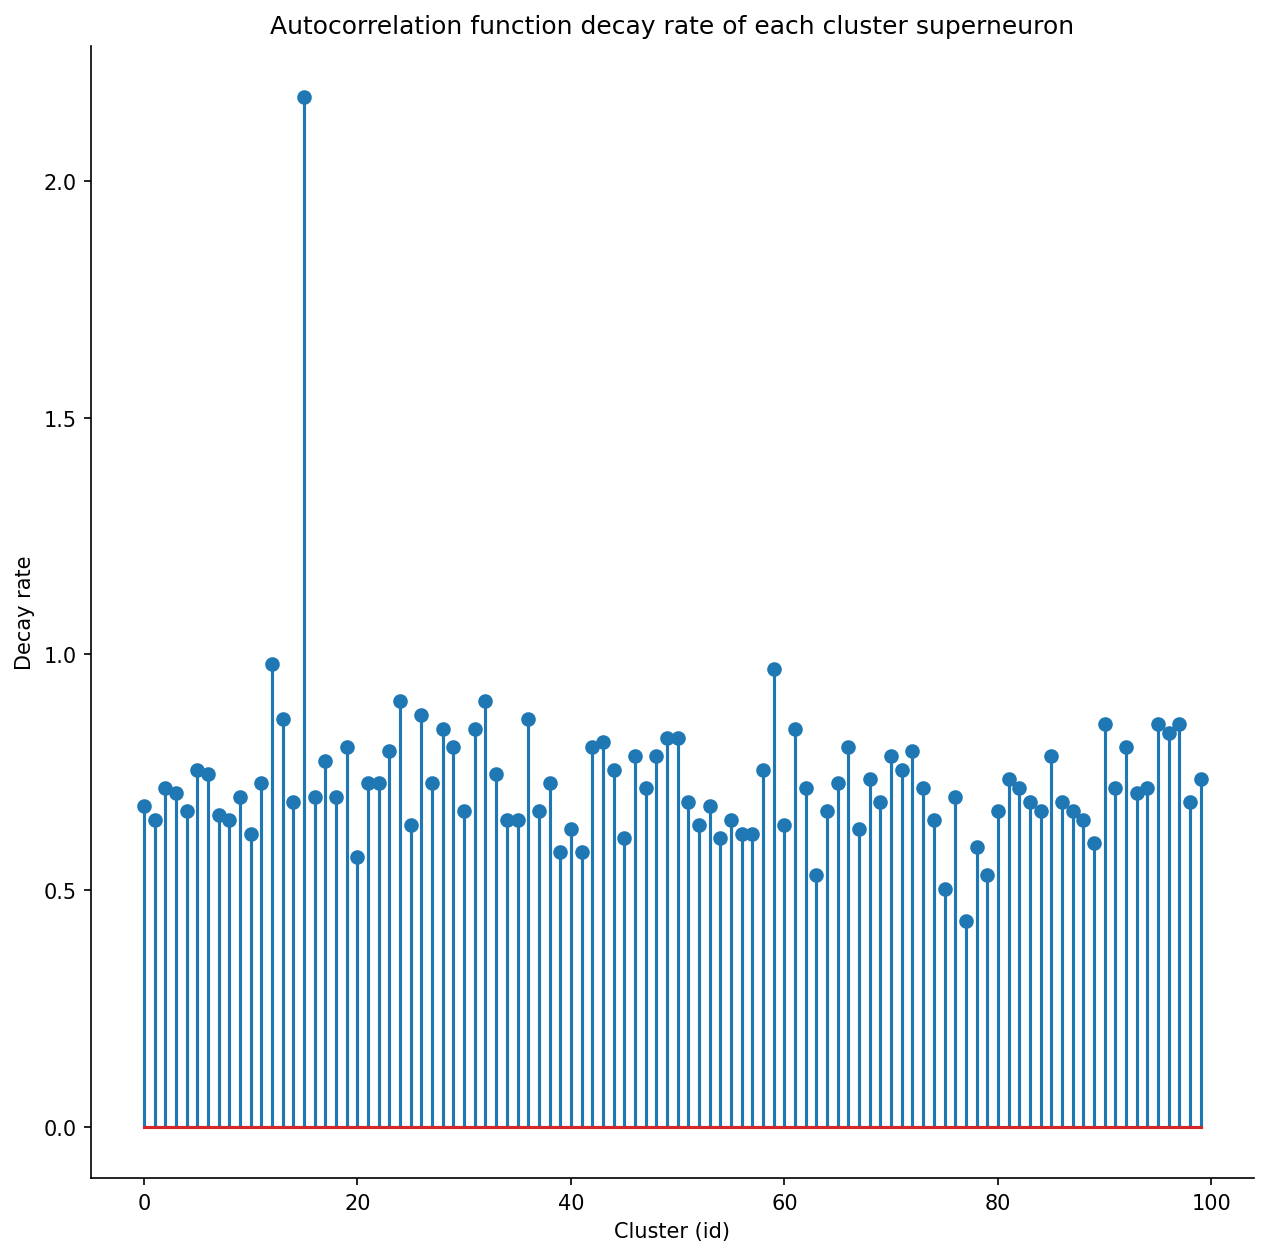

In [186]:
acf_decay_array = []
for clust in range(n_clusters):
    sn_acf, _ = Get_ACF_PACF(Splitted_sn[clust])
    acf_decay_array.append(compute_decay(sn_acf,interpolation_factor=100))
acf_decay_array = np.asarray(acf_decay_array)

plt.figure(figsize=(10,10), dpi=150)
plt.stem(acf_decay_array)
plt.ylabel('Decay rate')
plt.xlabel('Cluster (id)')
plt.title('Autocorrelation function decay rate of each cluster superneuron')
sns.despine()

# Population coupling and cross-correlation

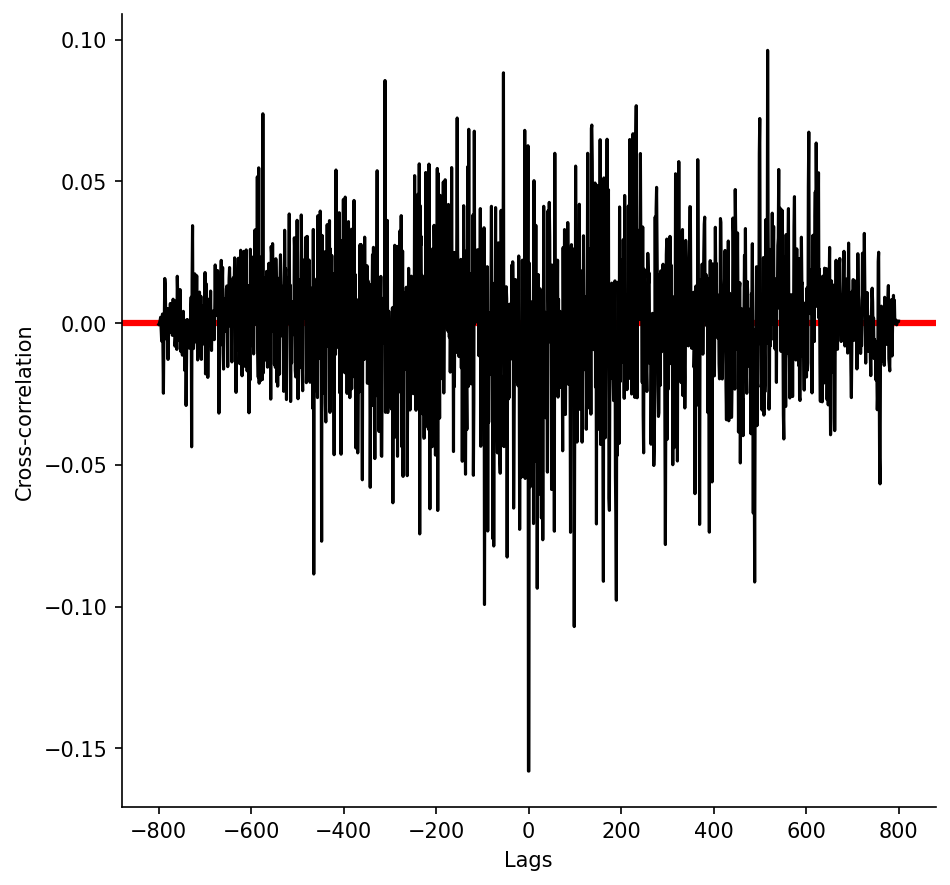

In [187]:
ccf_,_,_= Get_CCF(Splitted_spks,0,1)
plot_ccf(ccf_)

In [188]:
spks0, restvs0 = Get_subpopulationvsAll(spks,
                                labels = RM_model.embedding_clust, 
                                clust = 0,
                                xmin = 0, 
                                xmax = 800,
                                normalize=True)

In [189]:
def population_coupling(ref_cluster:np.array,population:np.array, pca:bool , n_comps:int=128):

    """
    Applies xcorr between the mean of a cluster and the mean of the population or the first principal component

    Parameters
    ----------
    ref_cluster: reference cluster to apply the analysis 
    population: rest of the population
    pca: boolean flag to select pca or mean 
    n_comps: number of components selected
    
    """

    if pca:
        pca_128 = PCA(n_components=n_comps).fit(population)
        pca_pop_ccf = ccf(Get_superneuron(ref_cluster),pca_128.components_[0],adjusted=False,fft=True)
        return pca_pop_ccf
    else:
        mean_pop_ccf = ccf(Get_superneuron(ref_cluster),Get_superneuron(population), adjusted=False,fft=True)
        return mean_pop_ccf

This gets the xcorr between one cluster vs the rest (pca and mean) at lag 0:

In [190]:
pca_coupling_list = []
mean_coupling_list = []

for clust in range(n_clusters):
    clust_ref, restvsref = Get_subpopulationvsAll(spks,
                                labels = RM_model.embedding_clust, 
                                clust = clust,
                                xmin = 0, 
                                xmax = 800)
    pca_pop_ccf = population_coupling(clust_ref, restvsref, pca=True, n_comps=128)
    mean_pop_ccf = population_coupling(clust_ref, restvsref, pca=False)
    xcorr_pca_tlag0 = pca_pop_ccf[0]
    xcorr_mean_tlag0 = mean_pop_ccf[0]

    pca_coupling_list.append(xcorr_pca_tlag0)
    mean_coupling_list.append(xcorr_mean_tlag0)

pca_coupling_arr = np.asarray(pca_coupling_list)
mean_coupling_arr = np.asarray(mean_coupling_list)

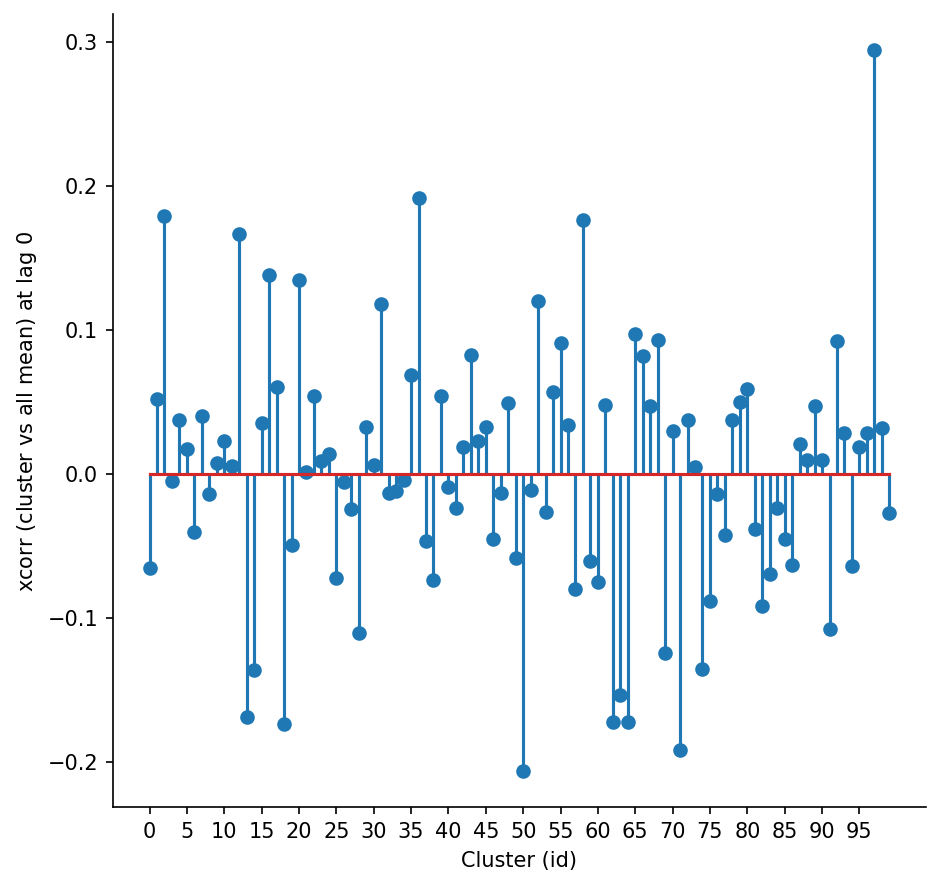

In [191]:
plt.figure(figsize=(7,7), dpi=150)
plt.stem(mean_coupling_arr)
plt.ylabel('xcorr (cluster vs all mean) at lag $0$')
plt.xlabel('Cluster (id)')
plt.xticks(np.arange(0,100,5))
sns.despine()

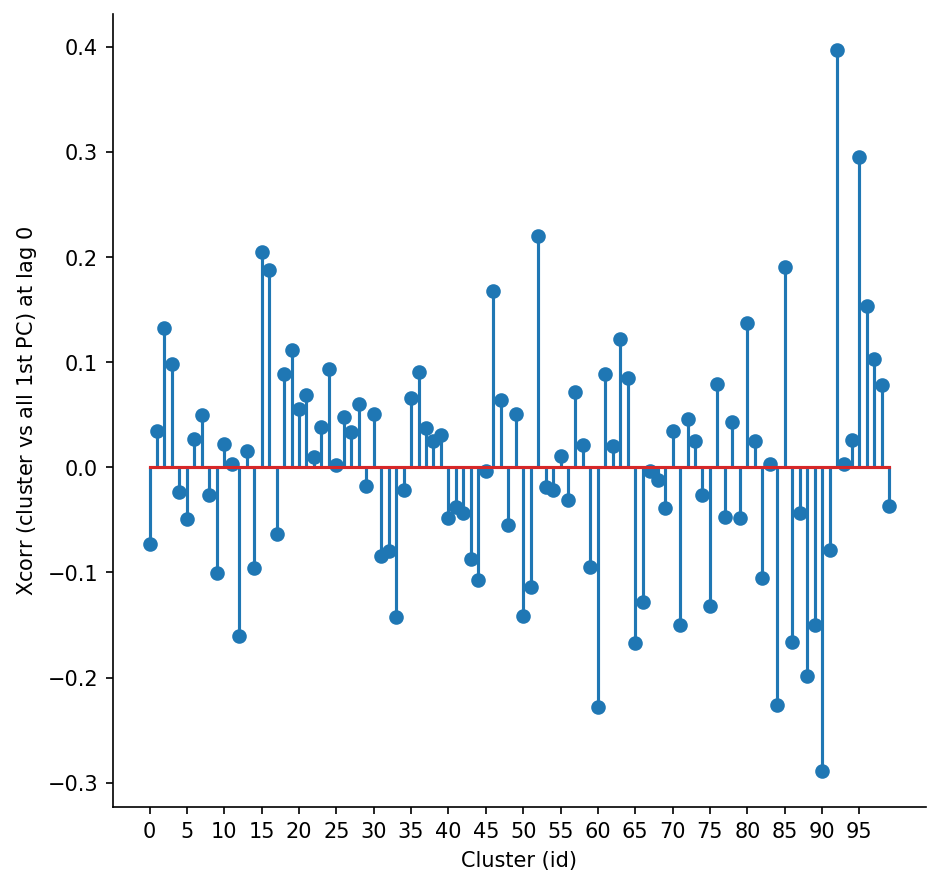

In [192]:
plt.figure(figsize=(7,7), dpi=150)
plt.stem(pca_coupling_arr)
plt.ylabel('Xcorr (cluster vs all 1st PC) at lag $0$')
plt.xlabel('Cluster (id)')
plt.xticks(np.arange(0,100,5))
sns.despine()

## Glosary:

*Autocorrelation* of the superneuron activity:

> probability of finding a spike at time $t+t^{'}$ given a spike at time t, for some range of lags  $t^{'}$

*Crosscorrelation* between superneurons:

> given that superneuron 1 emit a spike at time $t$ how likely is a spike from superneuron 2 at time $t+t^{'}$


# Sparseness

In [193]:
kurt_list=[]
skew_list=[]
for clust in range(n_clusters):
    kurt_list.append(kurtosis(Splitted_sn[clust]))
    skew_list.append(skew(Splitted_sn[clust]))
kurt_arr = np.asarray(kurt_list)
skew_arr = np.asarray(skew_list)

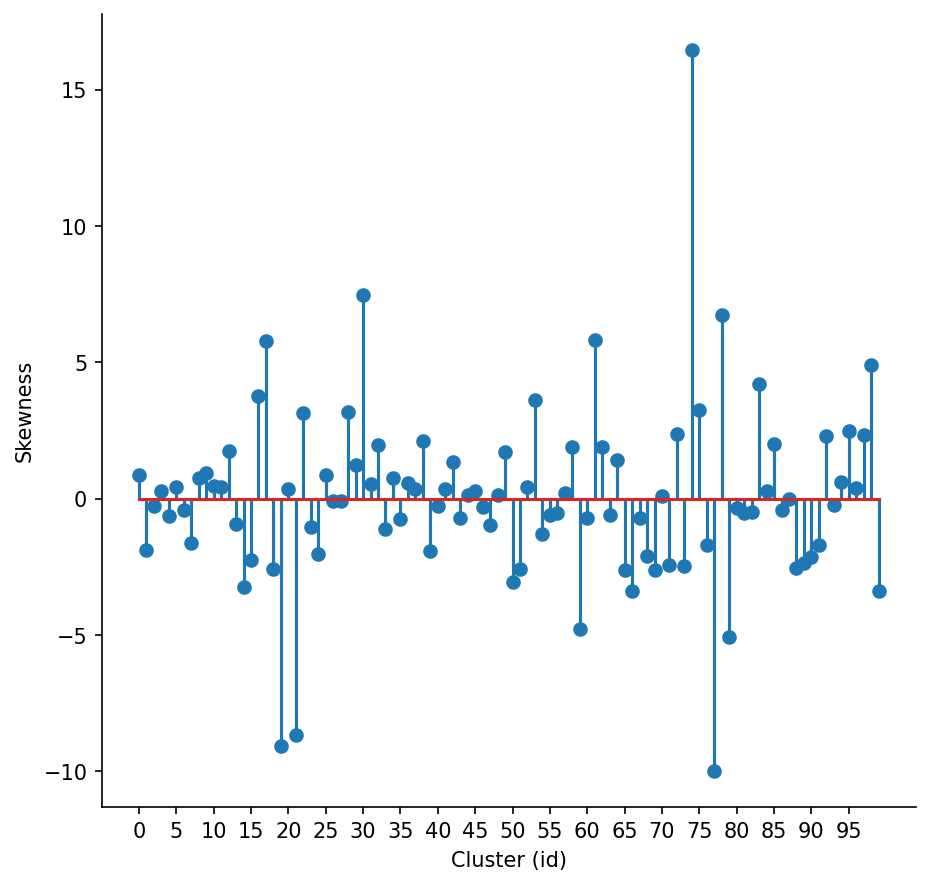

In [194]:
plt.figure(figsize=(7,7), dpi=150)
plt.stem(skew_arr)
plt.ylabel('Skewness')
plt.xlabel('Cluster (id)')
plt.xticks(np.arange(0,100,5))
sns.despine()

High skewness cluster:

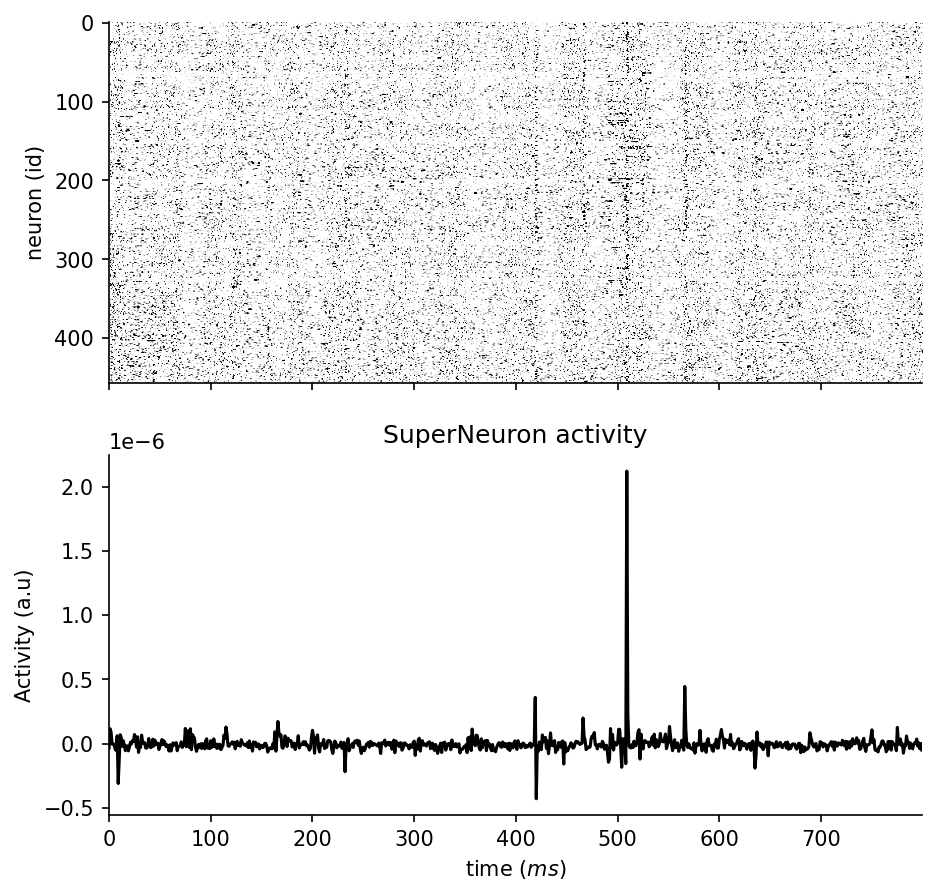

In [196]:
ClusterVisualizer(Splitted_spks[74])

Low Skewness cluster:

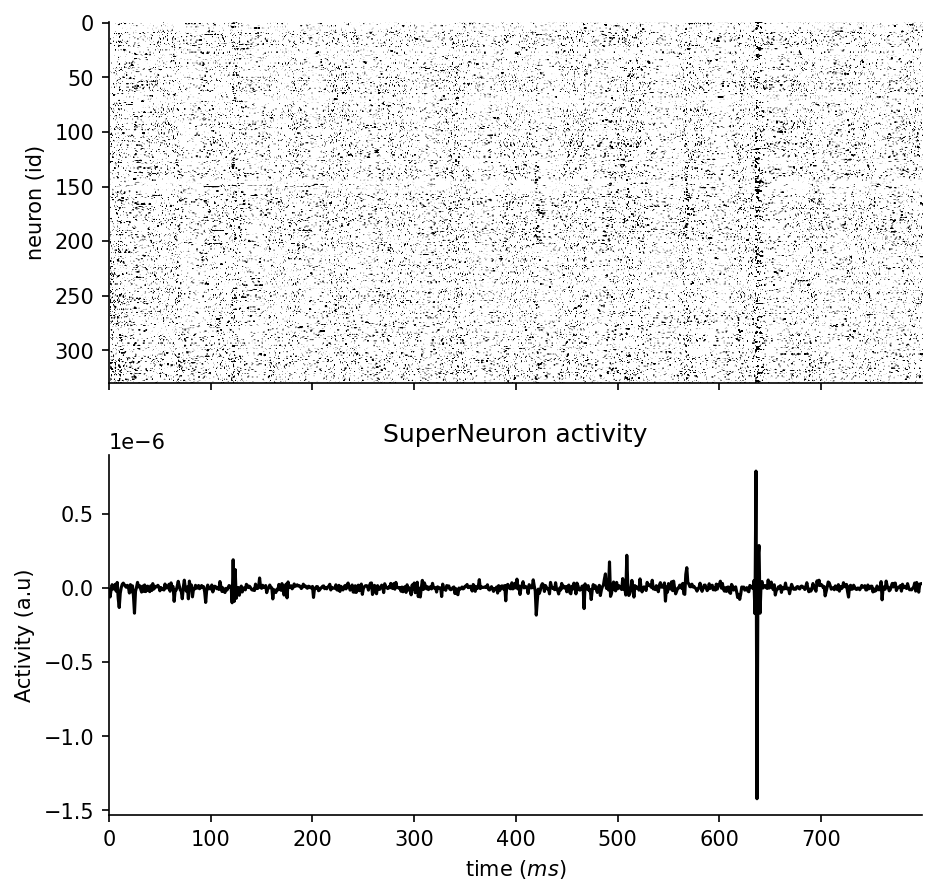

In [198]:
ClusterVisualizer(Splitted_spks[77])

# Spatial distribution exploration

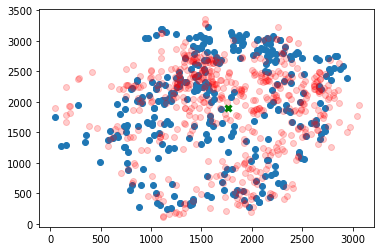

In [199]:
xpos0 = Splitted_xpos[99]
ypos0 = Splitted_ypos[99]
xpos1 = Splitted_xpos[97]
ypos1 = Splitted_ypos[97]
plt.scatter(xpos0,ypos0)
plt.scatter(xpos1,ypos1, color='red', alpha=0.2)
plt.scatter(np.mean(xpos1),np.mean(ypos1),marker='x', color = 'g', linewidths=3)

Lets compute the euclidean distance from each point from a central point, here defined as the mean for simplicity:

In [200]:
ec_dist_means = []
for clust in range(n_clusters):
    ec_list = []
    center = (np.mean(Splitted_xpos[clust]),np.mean(Splitted_ypos[clust]))

    for i in range(len(Splitted_xpos[clust])):
        ec = ((Splitted_xpos[clust][i]-center[0])**2 + (Splitted_ypos[clust][i]-center[1])**2)**0.5
        ec_list.append(ec)
    
    ec_array = np.asarray(ec_list)
    mean_distance = np.mean(ec_array)

    ec_dist_means.append(mean_distance) 

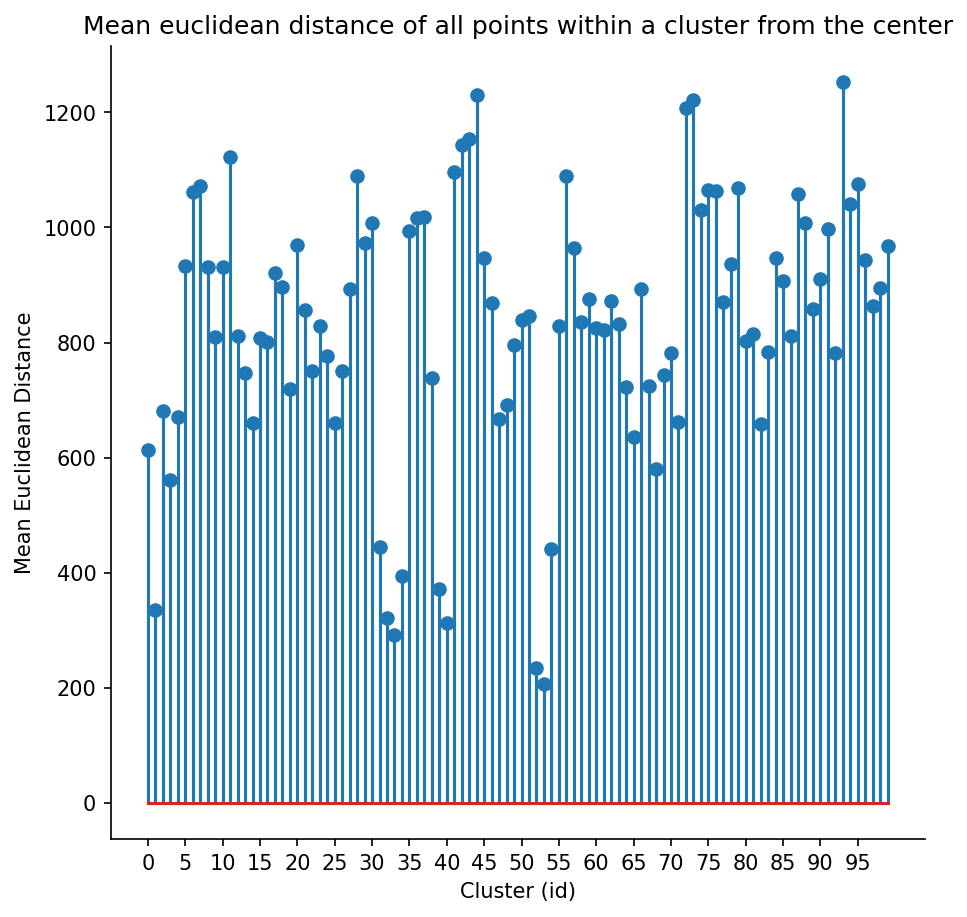

In [201]:
dist_means_arr = np.asarray(ec_dist_means)
plt.figure(figsize=(7,7), dpi=150)
plt.stem(dist_means_arr)
plt.ylabel('Mean Euclidean Distance')
plt.xlabel('Cluster (id)')
plt.title('Mean euclidean distance of all points within a cluster from the center')
plt.xticks(np.arange(0,100,5))
sns.despine()

# Cluster properties inspection

In [202]:
Properties_df = pd.DataFrame(
{
    'Cluster (id)' : np.arange(n_clusters),
    'Skewness': skew_arr,
    'Autocorr decay': acf_decay_array,
    'Xcorr (cluster vs rest mean)': mean_coupling_arr,
    'Xcorr (cluster vs rest  1st PC)': pca_coupling_arr,
    'Mean Euclidean Distance': dist_means_arr
}
)

Properties_df.set_index('Cluster (id)', inplace=True)

Properties_df.head()

Skewness  Autocorr decay  Xcorr (cluster vs rest mean)  \
Cluster (id)                                                           
0             0.857395        0.677638                     -0.065842   
1            -1.863769        0.648596                      0.051593   
2            -0.259105        0.716360                      0.179132   
3             0.278139        0.706680                     -0.005341   
4            -0.636140        0.667957                      0.037364   

              Xcorr (cluster vs rest  1st PC)  Mean Euclidean Distance  
Cluster (id)                                                            
0                                   -0.072923               612.661611  
1                                    0.034700               336.097541  
2                                    0.132087               681.251462  
3                                    0.098477               560.944602  
4                                   -0.023134               670.563211

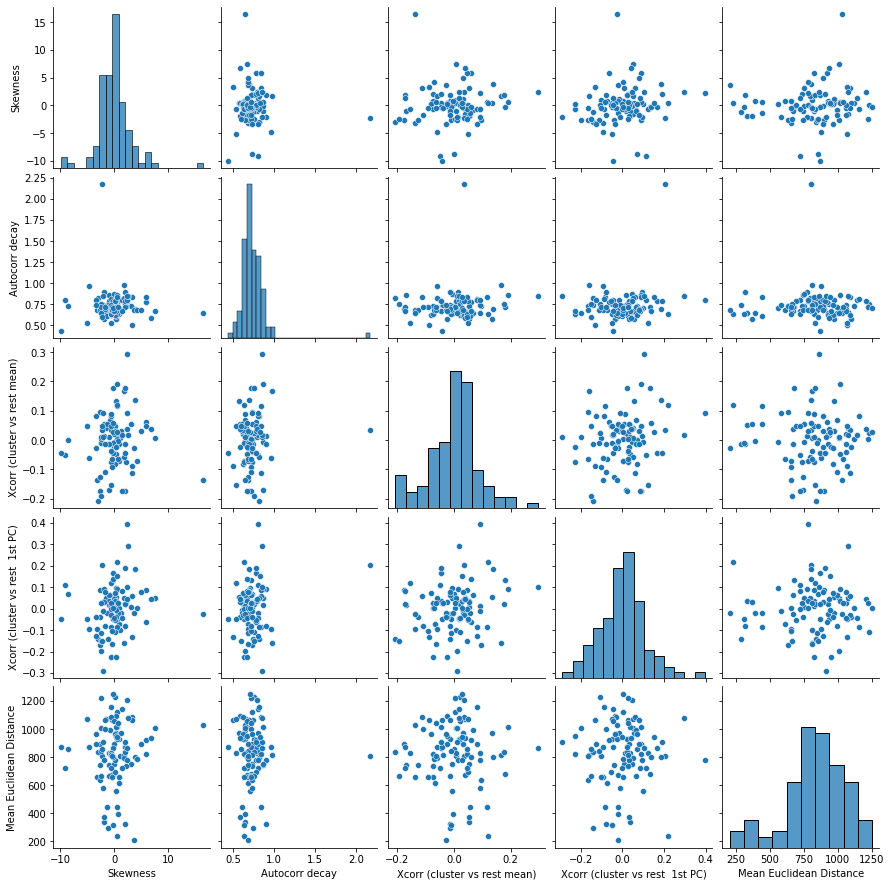

In [203]:
sns.pairplot(Properties_df)

Lets inspect activity from clusters with the following conditions:

In [206]:
interesting_clusters_not1pc = Properties_df.query('`Mean Euclidean Distance` > 750 & `Xcorr (cluster vs rest  1st PC)` < .3 & `Autocorr decay` < .75')                                                                       

In [207]:
interesting_clusters_not1pc

Skewness  Autocorr decay  Xcorr (cluster vs rest mean)  \
Cluster (id)                                                           
5             0.415155        0.755082                      0.016993   
6            -0.406240        0.745402                     -0.040586   
7            -1.634145        0.658277                      0.039724   
8             0.765827        0.648596                     -0.013956   
9             0.950584        0.696999                      0.007170   
...                ...             ...                           ...   
95            2.483231        0.851888                      0.018204   
96            0.397376        0.832527                      0.028523   
97            2.340755        0.851888                      0.294046   
98            4.903364        0.687318                      0.031581   
99           -3.379692        0.735721                     -0.027618   

              Xcorr (cluster vs rest  1st PC)  Mean Euclidean Distance  
Cluster (id)                                                            
5                                   -0.048830               932.572577  
6                                    0.026616              1062.380982  
7                                    0.050062              1071.901285  
8                                   -0.026720               931.407139  
9                                   -0.101071               809.411104  
...                                       ...                      ...  
95                                   0.295082              1075.613491  
96                                   0.153032               942.690414  
97                                   0.103413               862.955501  
98                                   0.078183               894.652873  
99                                  -0.037216               966.996065  

[71 rows x 5 columns]

In [208]:
StackedClusters_not1pc = ClusterStacker(Splitted_spks, interesting_clusters_not1pc.index)

Lets visualize the clusters that had a low cross correlation with the 1 PC of the whole population:

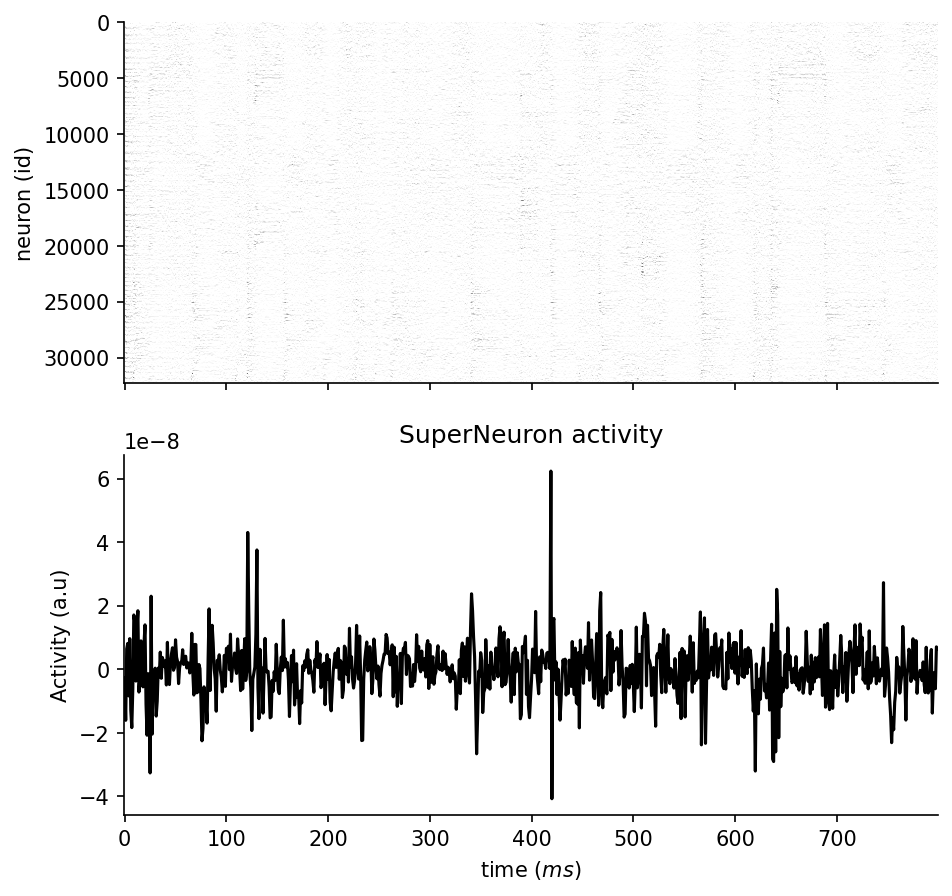

In [209]:
ClusterVisualizer(StackedClusters_not1pc)

In [165]:
n_comps = 128 
pca_comparison = PCA(n_components=n_comps).fit(zscore(spks[:,xmin:xmax],axis=1))

Mean of the clusters not related to 1st pc vs mean of the whole pop and 1st pc

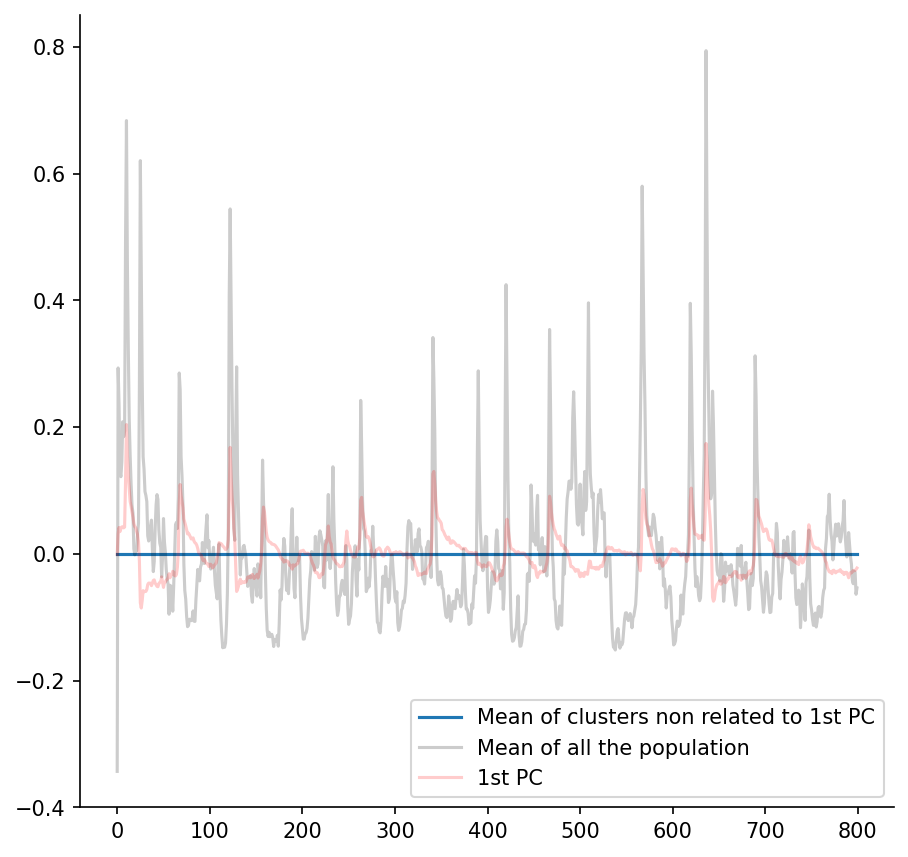

In [210]:
plt.figure(figsize=(7,7), dpi=150)
plt.plot(Get_superneuron(StackedClusters_not1pc), label = 'Mean of clusters non related to 1st PC')
plt.plot(Get_superneuron(zscore(spks[:,xmin:xmax],axis=1)), color = 'k', alpha=0.2, label ='Mean of all the population')
plt.plot(pca_comparison.components_[0], color = 'r', alpha=0.2, label = '1st PC')
sns.despine()
plt.legend()

Mean of the clusters not related to the mean of the population vs mean of the whole pop and 1st pc

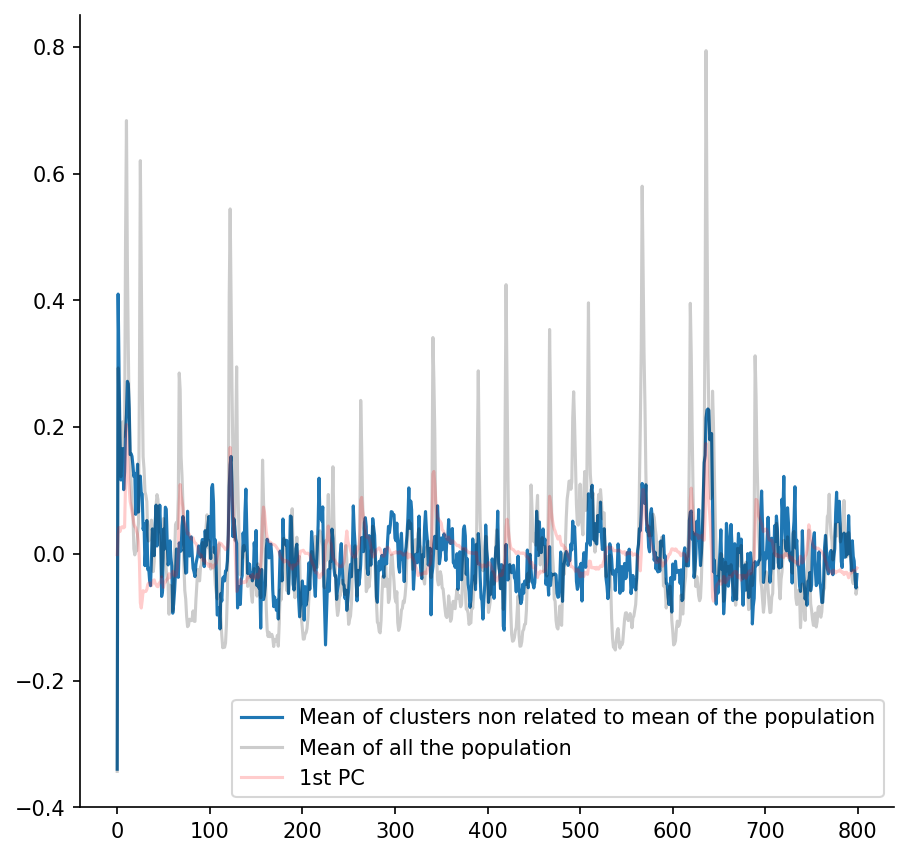

In [168]:
plt.figure(figsize=(7,7), dpi=150)
plt.plot(Get_superneuron(StackedClusters_notmean), label = 'Mean of clusters non related to mean of the population')
plt.plot(Get_superneuron(zscore(spks[:,xmin:xmax],axis=1)), color = 'k', alpha=0.2, label ='Mean of all the population')
plt.plot(pca_comparison.components_[0], color = 'r', alpha=0.2, label = '1st PC')
sns.despine()
plt.legend()

# Comparison between different algorithms 

## Needs work -v 

In [32]:
n_comps = 128 # chose to match rastermap output dimension 
pca_128 = PCA(n_components=n_comps).fit(spks)

*loadings* = linear combination of the original variables (aka timepoints in this case) from which the principal components (PCs) are constructed. `pca_128.components_`

In [33]:
U = spks@pca_128.components_.T
U.shape

(42568, 128)

### foor loop to try different number of clusters

* Just to test I took 100 clusters

In [176]:
clusters = [50,100,150,200,300,400]
labels = []
centroids = []
sse = []
sil_score = []
for ncluster in clusters:
    kmeans = KMeans(n_clusters=ncluster, n_init=1, random_state=0).fit(U)
    labels.append(kmeans.labels_)
    centroids.append(kmeans.cluster_centers_)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

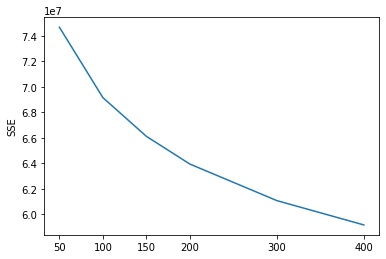

In [177]:
### This makes sense with more models fitted
sse = np.asarray(sse)
fig, ax1 = plt.subplots(1, 1, sharex=True)
clusters_arr = np.asarray(clusters)
ax1.plot(clusters_arr, sse)
ax1.set_xticks(clusters_arr)
ax1.set_ylabel("SSE")
###

# Just neurons sorted by cluster
## Todo: cluster rearrangement 

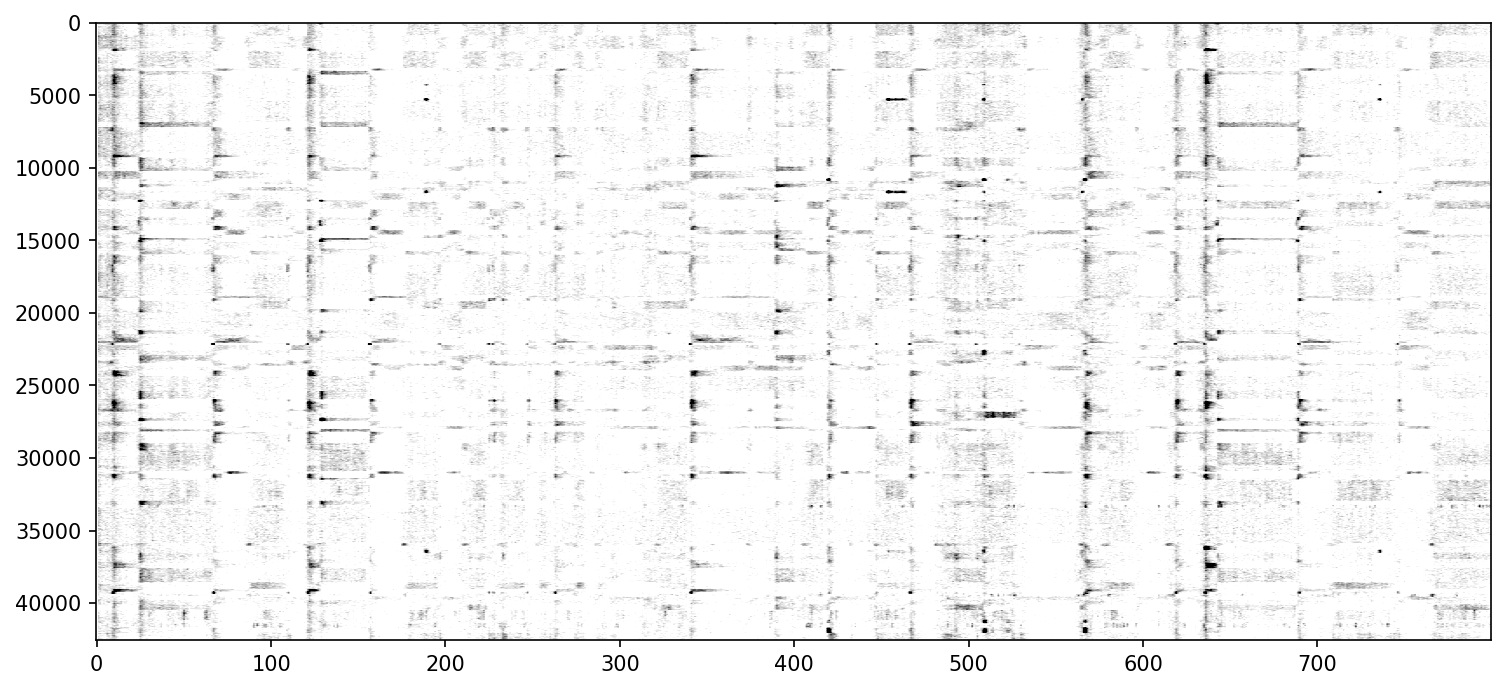

In [178]:
labels = np.asarray(labels[1]) #Getting the labels of the run with 100 clusters
centroids = np.asarray(centroids[1])
sort_idx=np.argsort(labels) 
pc_sort_knn=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_knn, vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Putting similar clusters close each other (?)
I will try to put clusters together by simply doing an agglomerative clustering on the clusters_centers of the Kmeans algo

In [187]:
from sklearn.cluster import AgglomerativeClustering
Cluster_rearrange=AgglomerativeClustering(n_clusters=12).fit(centroids)

In [188]:
order = np.argsort(Cluster_rearrange.labels_)
spks_ordered = np.empty([])
for ord in order:
    sort_idx=np.where(labels==ord)[0]
    spks_ordered = np.append(spks_ordered,spks[sort_idx,xmin:xmax])
spks_ordered = spks_ordered[1:].reshape(-1,800)

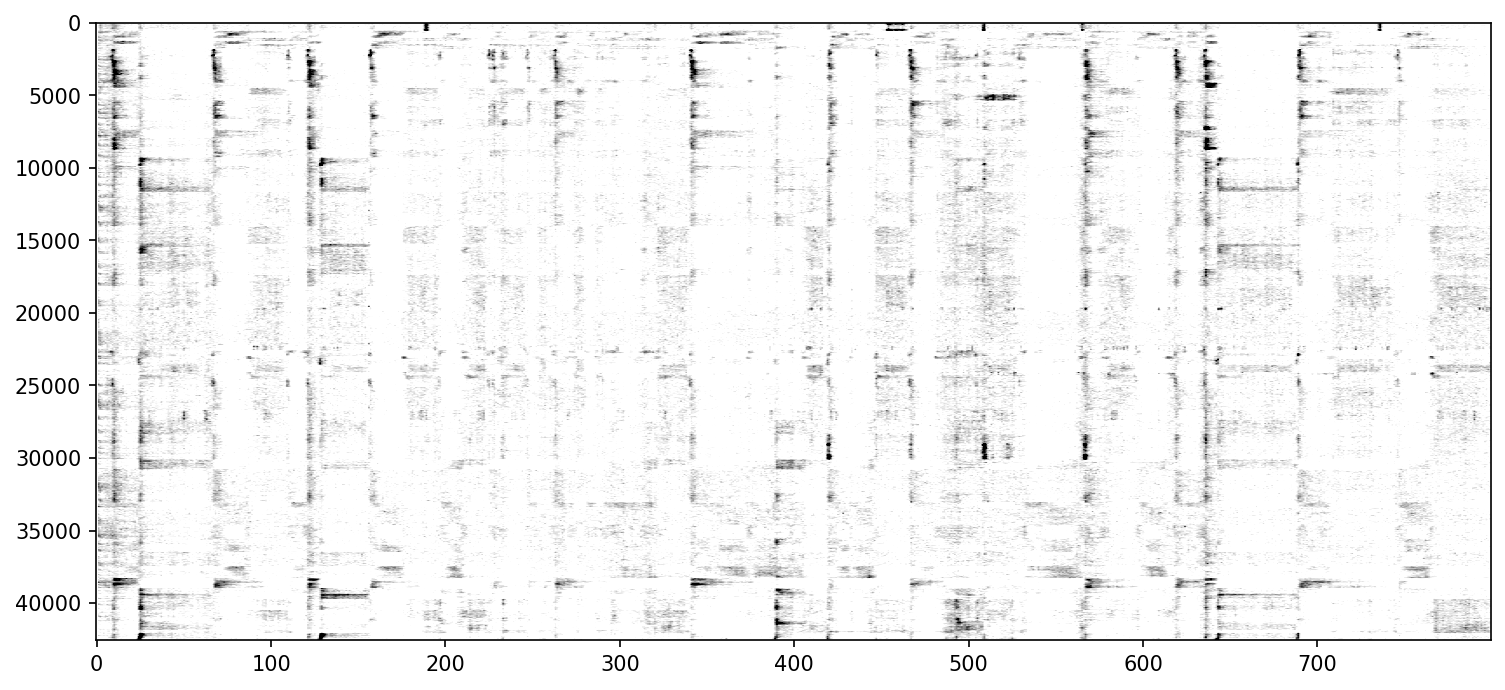

In [189]:
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(spks_ordered,axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Leinden Algo 

## Louvian - Leiden algo

## Louvian

>The Louvain algorithm searches for high-quality clusters by moving individual nodes—for instance individual articles in a citation network—from one cluster to another in such a way that the quality of the clusters is improved as much as possible. When clusters cannot be improved further by moving individual nodes, the Louvain algorithm does something ingenious: it aggregates the network, so that each cluster in the original network becomes a node in the aggregated network. In the aggregated network, the algorithm then starts to move individual nodes from one cluster to another.

--
## BIG FLAW: 

*Sometimes, a node functions as a middle man or a bridge for the rest of its cluster. Without that crucial node, the cluster would not be connected anymore. Since the Louvain algorithm keeps moving nodes from one cluster to another, at some point it may move the crucial node to a different cluster, thereby breaking the connectivity of the original cluster*

## Leiden

Leiden algorithm is able to split clusters instead of only merging them, as is done by the Louvain algorithm. By splitting clusters in a specific way, the Leiden algorithm guarantees that clusters are well-connected. Moreover, the algorithm guarantees more than this: if we run the algorithm repeatedly, we eventually obtain clusters that are subset optimal.

*This means that it is impossible to improve the quality of the clusters by moving one or more nodes from one cluster to another*

Rather than continuously checking for all nodes in a network whether they can be moved to a different cluster, as is done in the Louvain algorithm, the Leiden algorithm performs this check only for so-called unstable nodes. As a result, the Leiden algorithm does not only find higher quality clusters than the Louvain algorithm, it also does so in much less time.

In [194]:
import scanpy as sc
adata = sc.AnnData(spks)
sc.tl.pca(adata, n_comps=128)
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=128) #matching previous hyperparameters
sc.tl.leiden(adata, resolution=1)
leiden_labels = adata.obs['leiden'].astype(int)

In [198]:
print(f'number of clusters by leiden algo: { len(np.unique(leiden_labels))}')

number of clusters by leiden algo: 13


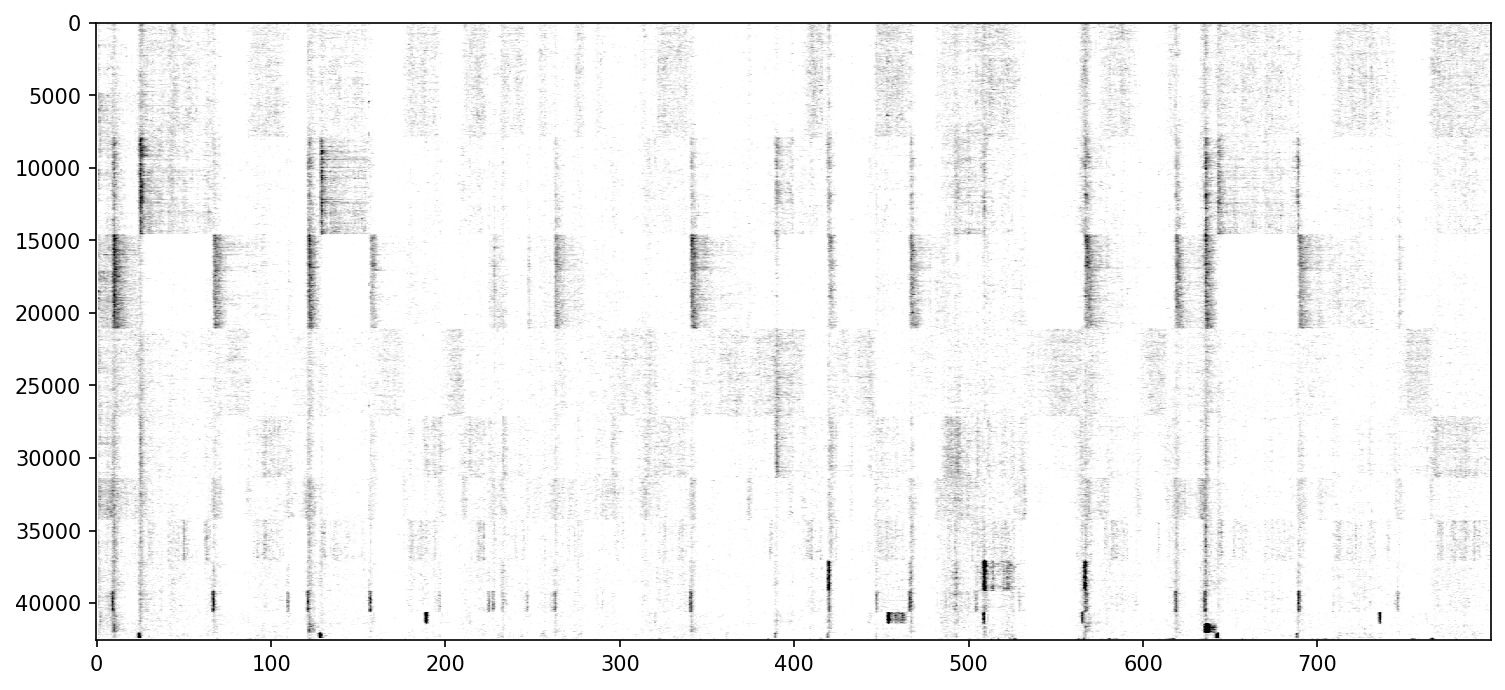

In [195]:
sort_idx=np.argsort(leiden_labels) 
pc_sort_leid=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_leid, vmin=0, vmax=2, cmap='gray_r', aspect='auto')